# Von Digitalisaten zu Wissensgraphen: Eine automatisierte Extraktion und semantische Modellierung biographischer Daten am Beispiel von Lebensbeschreibungen der Herrnhuter Brüdergemeine

## 5.2 OCR-Erkennung

### OCR-Erkennung

In [1]:
import cv2
import os
import pytesseract

In [2]:
# Ordner mit den jpg-Dateien 
base_folder = "data/5.2_OCR-Erkennung/jpg"

# Ordner für die TXT-Dateien
output_base = "data/5.2_OCR-Erkennung/txt"

In [3]:
# Durchlaufe alle Unterordner
for folder_name in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, folder_name)

    # Nur Verzeichnisse berücksichtigen
    if not os.path.isdir(folder_path):
        continue

    # Alle .jpg-Dateien holen
    jpeg_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')])

    if not jpeg_files:
        print(f"Keine .jpg-Dateien in Ordner: {folder_name}")
        continue

    # Ein neuer Ordner für jede Person erstellen (für txt-Output-Datei)
    output_folder = os.path.join(output_base, folder_name)
    os.makedirs(output_folder, exist_ok=True)

    # Bilder verarbeiten
    for jpeg_file in jpeg_files:
        img_path = os.path.join(folder_path, jpeg_file)
        img = cv2.imread(img_path)

        # Bildvorverarbeitung
        inverted_image = cv2.bitwise_not(img)
        gray_image = cv2.cvtColor(inverted_image, cv2.COLOR_BGR2GRAY)
        _, binary_image = cv2.threshold(gray_image, 120, 255, cv2.THRESH_BINARY)
        binary_image_contrast = cv2.convertScaleAbs(binary_image, alpha=2.0, beta=0)

        # OCR
        ocr_result = pytesseract.image_to_string(binary_image_contrast, lang="deu+frk")

        # TXT-Dateiname & Pfad
        txt_filename = os.path.splitext(jpeg_file)[0] + ".txt"
        txt_path = os.path.join(output_folder, txt_filename)

        # Speichern
        with open(txt_path, "w", encoding="utf-8") as txt_file:
            txt_file.write(ocr_result)

        print(f"Text gespeichert in: {txt_path}")


Text gespeichert in: data/5.2_OCR-Erkennung/txt/1851_Kölbing_Friedrich/28.txt
Text gespeichert in: data/5.2_OCR-Erkennung/txt/1851_Kölbing_Friedrich/29.txt
Text gespeichert in: data/5.2_OCR-Erkennung/txt/1851_Kölbing_Friedrich/30.txt
Text gespeichert in: data/5.2_OCR-Erkennung/txt/1851_Kölbing_Friedrich/31.txt
Text gespeichert in: data/5.2_OCR-Erkennung/txt/1851_Kölbing_Friedrich/32.txt
Text gespeichert in: data/5.2_OCR-Erkennung/txt/1851_Kölbing_Friedrich/33.txt
Text gespeichert in: data/5.2_OCR-Erkennung/txt/1851_Kölbing_Friedrich/34.txt
Text gespeichert in: data/5.2_OCR-Erkennung/txt/1851_Kölbing_Friedrich/35.txt
Text gespeichert in: data/5.2_OCR-Erkennung/txt/1851_Kölbing_Friedrich/36.txt
Text gespeichert in: data/5.2_OCR-Erkennung/txt/1851_Kölbing_Friedrich/37.txt
Text gespeichert in: data/5.2_OCR-Erkennung/txt/1851_Kölbing_Friedrich/38.txt
Text gespeichert in: data/5.2_OCR-Erkennung/txt/1851_Kölbing_Friedrich/39.txt
Text gespeichert in: data/5.2_OCR-Erkennung/txt/1851_Kölbing_Fri

### Verbesserung der OCR-Ergebnissen

In [9]:
import os
import re

In [10]:
# Textbereinigungsfunktion
def clean_text(text):
    if text is None:
        return ''
    
    # Silbentrennung am Zeilenende entfernen
    text = re.sub(r'-\n', '', text)
    text = re.sub(r'(?<=\d)\.', ',', text)

    # Exakte String-Ersetzungen (Formatierung/Zeilenumbrüche bleiben unangetastet)
    replacements = [
        ("ic)", "ich"),
        ("auc)", "auch"),
        ("nac)", "nach"),
        ("aud)", "auch"),
        ("Jh", "Ich"),
        ("IJ)", "Ich"),
        ("nad)", "nach"),
        ("fic", "sich"),
        ("i<ß", "ich"),
        ("ic?", "ich"),
        ("zurü>", "zurück"),
        ("durc<zumachen", "durchzumachen"),
        ("» ", ""),
        ('!', ' '),
        ('/', ' '),
        ("'", ' '),
        (',', ' '),
        ("„", " "),
        ("“", " ")
    ]
    for old, new in replacements:
        text = text.replace(old, new)
        

    # KEINE Whitespace-Normalisierung, KEIN strip()
    return text

# Ordnerpfad
folder_path = r"data/5.2_OCR-Erkennung/txt"

# Alle .txt-Dateien im Ordner UND in Unterordnern durchgehen
for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.lower().endswith(".txt"):
            file_path = os.path.join(root, filename)

            # Zeilenenden beibehalten: newline="" verhindert Übersetzung der Zeilenumbrüche
            with open(file_path, "r", encoding="utf-8", newline="") as f:
                original = f.read()

            cleaned = clean_text(original)

            # Nur schreiben, wenn sich etwas geändert hat (schont Zeitstempel)
            if cleaned != original:
                with open(file_path, "w", encoding="utf-8", newline="") as f:
                    f.write(cleaned)
                # Optionales Feedback:
                # print(f"Bereinigt: {file_path}")


## 5.3 XML/TEI-Modellierung (Teil 1)

### Erstellung einer XML-Grundstruktur

In [203]:
import re
import os
import xml.etree.ElementTree as ET
from xml.dom import minidom

In [204]:
# Ordner mit txt-Dateien
base_folder = "data/5.2_OCR-Erkennung/txt"

In [205]:
# Die Dateien werden iteriert
for folder_name in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, folder_name)

    if not os.path.isdir(folder_path):
        continue

    txt_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.txt')])

    if not txt_files:
        print(f"Keine .txt-Dateien in Ordner: {folder_name}")
        continue
    
    # === Erstelle die Root-Element der XML-Struktur ===
    root = ET.Element("TEI")
    root.set("version", "4.8.1")
    root.set("xmlns", "http://www.tei-c.org/ns/1.0")
    
        # === teiHeader-Struktur ===
    headerTEI_el = ET.SubElement(root, "teiHeader")
    fileDesc_el = ET.SubElement(headerTEI_el, "fileDesc")
    titleStmt_el = ET.SubElement(fileDesc_el, "titleStmt")
    
    titleStmt_el.append(ET.Comment("Titel muss definiert werden. Nach der Korrektur wird der Kommentar gelöscht"))
    ET.SubElement(titleStmt_el, "title")

    titleStmt_el.append(ET.Comment("Autor muss definiert werden. Nach der Korrektur wird der Kommentar gelöscht"))
    ET.SubElement(titleStmt_el, "author")

    # respStmt
    respStmt_el = ET.SubElement(titleStmt_el, "respStmt")
    resp_el = ET.SubElement(respStmt_el, "resp")
    resp_el.text = "XML-Modelling compiled by"
    name_el = ET.SubElement(respStmt_el, "name")
    name_el.text = "Svetlana Yakutina"

    # publicationStmt
    publicationStmt_el = ET.SubElement(fileDesc_el, "publicationStmt")
    publisher_el = ET.SubElement(publicationStmt_el, "publisher")
    orgName_el = ET.SubElement(publisher_el, "orgName")
    orgName_el.text = "Verlag der Unitäts-Buchhandlung"

    pubPlace_el = ET.SubElement(publicationStmt_el, "pubPlace")
    pubPlace_el.text = "Gnadau (Germany)"

    availability_el = ET.SubElement(publicationStmt_el, "availability")
    p_header_el = ET.SubElement(availability_el, "p")
    orgName_el_ = ET.SubElement(p_header_el, "orgName")
    orgName_el_.text = "Memorial University of Newfoundland"

    publicationStmt_el.append(ET.Comment("Date muss definiert werden. Nach der Korrektur wird der Kommentar gelöscht"))
    ET.SubElement(publicationStmt_el, "date")

    publicationStmt_el.append(ET.Comment("Ref muss definiert werden. Nach der Korrektur wird der Kommentar gelöscht"))
    ET.SubElement(publicationStmt_el, "ref")

    # sourceDesc Struktur
    sourceDesc_el = ET.SubElement(fileDesc_el, "sourceDesc")
    bibl_el = ET.SubElement(sourceDesc_el, "bibl", type="j")
    bibl_el.text = "Nachrichten aus der Brüder-Gemeine"

    # biblFull Struktur
    biblFull_el = ET.SubElement(sourceDesc_el, "biblFull")
    titleStmt_el_ = ET.SubElement(biblFull_el, "titleStmt")
    ET.SubElement(titleStmt_el_, "title").text = "Nachrichten aus der Brüder-Gemeine"
    ET.SubElement(titleStmt_el_, "author").text = "Unbekannt"

    editionStmt_el = ET.SubElement(biblFull_el, "editionStmt")
    ET.SubElement(editionStmt_el, "edition").text = "Digitale Ausgabe der Zeitschrift"

    publicationStmt_el_ = ET.SubElement(biblFull_el, "publicationStmt")
    ET.SubElement(publicationStmt_el_, "publisher").text = "Verlag der Unitäts-Buchhandlung"

    seriesStmt_el = ET.SubElement(biblFull_el, "seriesStmt")
    title_el__ = ET.SubElement(seriesStmt_el, "title", level="j", type="main")
    title_el__.text = "Nachrichten aus der Brüder-Gemeine"
    ET.SubElement(seriesStmt_el, "biblScope", unit="volume").text = "1856-1894"
    seriesStmt_el.append(ET.Comment("Erscheinungsjahr muss definiert werden"))
    seriesStmt_el.append(ET.Comment("Seiten müssen definiert werden"))
    ET.SubElement(seriesStmt_el, "biblScope", unit="issue")
    ET.SubElement(seriesStmt_el, "biblScope", unit="page")

    notesStmt_el = ET.SubElement(biblFull_el, "notesStmt")
    note_el = ET.SubElement(notesStmt_el, "note", type="fileFormat")
    note_el.text = "application/pdf"

    # msDesc Struktur
    msDesc_el = ET.SubElement(sourceDesc_el, "msDesc")
    msIdentifier_el = ET.SubElement(msDesc_el, "msIdentifier")
    ET.SubElement(msIdentifier_el, "repository").text = "Memorial University of Newfoundland"
    idno_el = ET.SubElement(msIdentifier_el, "idno")
    idno_el_ = ET.SubElement(idno_el, "idno", type="URLCatalogue")
    idno_el_.text = "https://dai.mun.ca/digital/nachrichten/"

    # === Textstruktur ===
    text_el = ET.SubElement(root, "text")
    body_el = ET.SubElement(text_el, "body")
    div_el = ET.SubElement(body_el, "div")

    # alle TXT-Dateien durchlaufen
    for txt_file in txt_files:
        txt_file_path = os.path.join(folder_path, txt_file)
        with open(txt_file_path, 'r', encoding='utf-8') as f:
            raw_text = f.read()

        #vor jeder nuen Seite wird geschloßenes pb-Tad zugefügt, das Attribut n bekommt den Dateinamen ohne txt
        file_base = os.path.splitext(txt_file)[0]
        pb_el = ET.SubElement(div_el, "pb", n=file_base)

        #alle Absätze wurden anhand von doppelten Zeilenumbruch in p-Tag gepackt
        paragraphs = raw_text.split('\n\n')
        for para in paragraphs:
            para = para.strip()
            if para:
                p_el = ET.SubElement(div_el, "p")
                p_el.text = para
                
    # XML-Datei erzeugen
    xml_str = ET.tostring(root, encoding='utf-8')
    pretty_xml = minidom.parseString(xml_str).toprettyxml(indent="  ")

    os.makedirs("data/5.3_TEI-Modellierung", exist_ok=True)
    output_filename = f"{folder_name}.xml"
    output_path = os.path.join("data/5.3_TEI-Modellierung", output_filename)

    with open(output_path, 'w', encoding='utf-8') as output_file:
        output_file.write(pretty_xml)

    print(f"XML-Datei erstellt: {output_path}")


XML-Datei erstellt: data/5.3_TEI-Modellierung/1851_Kölbing_Friedrich.xml
XML-Datei erstellt: data/5.3_TEI-Modellierung/1860_Suhl_D_W.xml
XML-Datei erstellt: data/5.3_TEI-Modellierung/1847_Schmitt_J_H.xml
XML-Datei erstellt: data/5.3_TEI-Modellierung/1856_Lemmerz_J.xml
XML-Datei erstellt: data/5.3_TEI-Modellierung/1855_Hoffmann_M_E.xml
XML-Datei erstellt: data/5.3_TEI-Modellierung/1893_Bonatz_J_A.xml
XML-Datei erstellt: data/5.3_TEI-Modellierung/1875_Breutel_J_C.xml
XML-Datei erstellt: data/5.3_TEI-Modellierung/1849_Hoffman_Johannes_Friedrich.xml
XML-Datei erstellt: data/5.3_TEI-Modellierung/1820_Schulz_Johann_Gottlieb.xml
XML-Datei erstellt: data/5.3_TEI-Modellierung/1884_Stuhl_S_E.xml
XML-Datei erstellt: data/5.3_TEI-Modellierung/1862_Lemmerz_A.xml
XML-Datei erstellt: data/5.3_TEI-Modellierung/1861_Kölbing_C_R.xml
XML-Datei erstellt: data/5.3_TEI-Modellierung/1862_Beck_J_C.xml
XML-Datei erstellt: data/5.3_TEI-Modellierung/1823_Bonatz_Johanna.xml
XML-Datei erstellt: data/5.3_TEI-Modell

## 5.3 XML/TEI-Modellierung (Teil 2)

In [206]:
import spacy
import os

In [207]:
# Speichern der Sätze in einer Textdatei
with open("data/5.2_OCR-Erkennung/txt/1823_Bonatz_Johanna/214.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [208]:
#spaCy-Modell laden
model = "de_core_news_lg"         
nlp = spacy.load(model)

#NER ausführen
doc = nlp(text)

#Etntitäts ausgeben
for ent in doc.ents:
    print(ent.text, ent.label_)

geplagtes PER
Entſchluß PER
genthum PER
beveſtigt   LOC
Waſſer LOC
dieſer Todesnoth MISC
verſprach PER
ſeyn PER
ven Kleidern PER
faſt günzs PER
Brüdergemeine ORG
Groß LOC
Hennersdorf LOC
Catharinenhof LOC
Hauſe PER
Herrnhut LOC
July PER
demſelben LOC
Jeſu PER


In [209]:
# Liste aller NER-Labels anzeigen
labels = nlp.get_pipe("ner").labels
print(labels)

('LOC', 'MISC', 'ORG', 'PER')


In [210]:
import spacy
import os
import re
from lxml import etree as ET

In [211]:
# spaCy-Modell importieren
ner_model = spacy.load("data/5.4.1_NER/output/model-best")

In [212]:
# Liste aller NER-Labels anzeigen
labels = ner_model.get_pipe("ner").labels
print(labels)

('DATE', 'LOC', 'ORG', 'PER')


In [213]:
# XML-Dateien importieren
input_dir = "data/5.3_TEI-Modellierung"

In [214]:
# Namespace-Map für TEI
ns = {'tei': 'http://www.tei-c.org/ns/1.0'}

In [215]:
# Entität-Typen zu Tags zuordnen
tag_map = {"PER": "persName", "LOC": "placeName", "DATE": "date"}


# XML-Parser konfigurieren
parser = ET.XMLParser(remove_blank_text=True)

# Alle XML-Dateien im Verzeichnis rekursiv durchsuchen
for root_dir, _, files in os.walk(input_dir):
    for file_name in files:
        if file_name.endswith(".xml"):
            file_path = os.path.join(root_dir, file_name)
            print(f"Verarbeite: {file_path}")

            # XML-Datei laden
            tree = ET.parse(file_path, parser)
            root = tree.getroot()

            # Alle <p>-Elemente finden
            p_elems = root.xpath('.//tei:text//tei:p', namespaces=ns)

            # Jeden Absatz bearbeiten
            for p_elem in p_elems:
                # Leere Absätze überspringen
                if p_elem.text is None and len(p_elem) == 0:
                    continue

                # Text aus dem Absatz holen und bereinigen
                full_text = "".join(p_elem.itertext())
                cleaned_text = re.sub(r'(?<=\d)\.(?=\s|$)', '', full_text).strip()

                # Absatz leeren
                p_elem.clear()

                # In Sätze aufteilen (am Punkt + Leerzeichen)
                sentences = [s.strip() for s in cleaned_text.split('. ') if s.strip()]

                for sentence in sentences:
                    doc = ner_model(sentence)
                    ents = [ent for ent in doc.ents if ent.label_ in tag_map]

                    if not ents:
                        p_elem.text = (p_elem.text or '') + sentence + ". "
                        continue

                    # Neues <s>-Element erstellen
                    s_elem = ET.Element("s")
                    last_idx = 0

                    for ent in ents:
                        # Text vor der Entität einfügen
                        if ent.start_char > last_idx:
                            chunk = sentence[last_idx:ent.start_char]
                            if len(s_elem) == 0:
                                s_elem.text = chunk
                            else:
                                s_elem[-1].tail = chunk

                        # Entität als XML-Element einfügen
                        tag = tag_map[ent.label_]
                        ent_elem = ET.Element(tag)
                        ent_elem.text = ent.text
                        s_elem.append(ent_elem)

                        last_idx = ent.end_char

                    # Rest vom Satz + Punkt einfügen
                    remaining = sentence[last_idx:] + ". "
                    if len(s_elem) == 0:
                        s_elem.text = remaining
                    else:
                        s_elem[-1].tail = remaining

                    p_elem.append(s_elem)

            # Datei überschreiben
            tree.write(file_path, encoding='utf-8', pretty_print=True, xml_declaration=True)
            print(f"Überschrieben: {file_path}")


Verarbeite: data/5.3_TEI-Modellierung/1893_Bonatz_J_A.xml
Überschrieben: data/5.3_TEI-Modellierung/1893_Bonatz_J_A.xml
Verarbeite: data/5.3_TEI-Modellierung/1856_Lemmerz_J.xml
Überschrieben: data/5.3_TEI-Modellierung/1856_Lemmerz_J.xml
Verarbeite: data/5.3_TEI-Modellierung/1820_Schulz_Johann_Gottlieb.xml
Überschrieben: data/5.3_TEI-Modellierung/1820_Schulz_Johann_Gottlieb.xml
Verarbeite: data/5.3_TEI-Modellierung/1836_Küster_Johann_Adolph.xml
Überschrieben: data/5.3_TEI-Modellierung/1836_Küster_Johann_Adolph.xml
Verarbeite: data/5.3_TEI-Modellierung/1847_Schmitt_J_H.xml
Überschrieben: data/5.3_TEI-Modellierung/1847_Schmitt_J_H.xml
Verarbeite: data/5.3_TEI-Modellierung/1859_Fritsch_Johannes.xml
Überschrieben: data/5.3_TEI-Modellierung/1859_Fritsch_Johannes.xml
Verarbeite: data/5.3_TEI-Modellierung/1851_Kölbing_Friedrich.xml
Überschrieben: data/5.3_TEI-Modellierung/1851_Kölbing_Friedrich.xml
Verarbeite: data/5.3_TEI-Modellierung/1862_Schulz_J_B.xml
Überschrieben: data/5.3_TEI-Modellierun

## 5.4	Informationsextraktion aus Texten

### 5.4.2 Relationsextraktion 

#### Sätzenextraktion

In [2]:
import os
import json
import re
from lxml import etree as ET

In [3]:
# Pfade
input_dir = "data/5.3_TEI-Modellierung/5.3_TEI_bereinigt"
output_file = "data/5.4.2_RE"

In [4]:
# XML-Namespaces
ns = {'tei': 'http://www.tei-c.org/ns/1.0'}

In [5]:
# Entfernung von Leerzeichen, Tabs, Zeilenumbrüche usw.
def clean_text(text):
    if not text:
        return ''
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [6]:
all_results = []

# Alle XML-Dateien im Verzeichnis durchgehen
for filename in os.listdir(input_dir):
    if filename.endswith(".xml"):
        file_path = os.path.join(input_dir, filename)

        try:
            parser = ET.XMLParser(remove_blank_text=True)
            tree = ET.parse(file_path, parser)
            root = tree.getroot()

            # Metadaten: Autor und Referenz
            author_element = root.xpath('.//tei:teiHeader//tei:author', namespaces=ns)
            autor = clean_text(author_element[0].text) if author_element and author_element[0].text else ''

            ref_element = root.xpath('.//tei:teiHeader//tei:ref', namespaces=ns)
            ref = clean_text(ref_element[0].text) if ref_element and ref_element[0].text else ''

            # Sätze aus head-Element 
            head_elements = root.xpath('.//tei:text//tei:head', namespaces=ns)
            for head in head_elements:
                head_text = clean_text(''.join(head.itertext()))

                head_personen = set()
                head_organisationen = set()
                head_orte = set()
                head_date = set()

                for pn in head.xpath('.//tei:persName', namespaces=ns):
                    if pn.text:
                        head_personen.add(clean_text(pn.text))
                for on in head.xpath('.//tei:orgName', namespaces=ns):
                    if on.text:
                        head_organisationen.add(clean_text(on.text))
                for pln in head.xpath('.//tei:placeName', namespaces=ns):
                    if pln.text:
                        head_orte.add(clean_text(pln.text))
                for dt in head.xpath('.//tei:date', namespaces=ns):
                    if dt.text:
                        head_date.add(clean_text(dt.text))

                result = {
                    "text": head_text,
                    "personen": sorted(head_personen),
                    "orte": sorted(head_orte),
                    "organisationen": sorted(head_organisationen),
                    "date": sorted(head_date),
                    "datei": filename,
                    "autor": autor,
                    "ref": ref
                }
                all_results.append(result)

            # Sätze aus s-Element
            s_elements = root.xpath('.//tei:text//tei:s', namespaces=ns)
            for s in s_elements:
                s_text = clean_text(''.join(s.itertext()))

                s_personen = set()
                s_organisationen = set()
                s_orte = set()
                s_date = set()

                for pn in s.xpath('.//tei:persName', namespaces=ns):
                    if pn.text:
                        s_personen.add(clean_text(pn.text))
                for on in s.xpath('.//tei:orgName', namespaces=ns):
                    if on.text:
                        s_organisationen.add(clean_text(on.text))
                for pln in s.xpath('.//tei:placeName', namespaces=ns):
                    if pln.text:
                        s_orte.add(clean_text(pln.text))
                for dt in s.xpath('.//tei:date', namespaces=ns):
                    if dt.text:
                        s_date.add(clean_text(dt.text))

                result = {
                    "text": s_text,
                    "personen": sorted(s_personen),
                    "orte": sorted(s_orte),
                    "organisationen": sorted(s_organisationen),
                    "date": sorted(s_date),
                    "datei": filename,
                    "autor": autor,
                    "ref": ref
                }
                all_results.append(result)

        except ET.XMLSyntaxError as e:
            print(f"Fehler beim Parsen von {filename}: {e}")
        except Exception as e:
            print(f"Anderer Fehler bei {filename}: {e}")

In [7]:
with open("data/5.4.2_RE/sätze.json", 'w', encoding='utf-8') as f:
    json.dump(all_results, f, ensure_ascii=False, indent=2)

### RE

In [16]:
import json
from typing import List, Optional, Literal
from pydantic import BaseModel, Field
from langchain.chat_models import ChatOllama
from langchain.prompts import PromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser

In [17]:
# Lade Eingabedaten
with open("data/5.4.2_RE/sätze.json", "r", encoding="utf-8") as f:
    input_data = json.load(f)

In [18]:
# Neue Entity- und Relationstypen
entity_types = ['person', 'location', 'organisation', 'date']

relation_types = [
    # Biografische Basisdaten
    "geboren", "gestorben", "gestorben",
    "begraben",

    # Wohn- und Wirkorte
    "wohnhaft", "leben", "wirkken", "aufenthalt",

    # Bildung und Beruf
    "ausgebildet", "studierte",
    "lehre", 
    "tätig", "tätig",
    "war", "beschäftigt", "mitglied",
    

    # Familie
    "verheiratet", "kind", "eltern", "geschwister",

    # Religion & Kirche
    "getauft", "beigetreten", "konfirmiert", "heiliges_abendmahl",

    # Interessen & Themen
    "interessiert sich", "beschäftigt sich", 

    # Reisen & Aufenthalte
    "reisen", "besuchen", "ankommen", "abgereisen",
    "aufhalten", "zurückkehren", "verließen", "fahren"]

In [19]:
class ExtractedInfo(BaseModel):
    subjekt: str = Field(description="extrahierte Subjekt-Entität, z.B. Daniel Wilhelm Suhl, ich, er, wir, meine l. Frau, seliger Bruder")
    subjekt_type: str = Field(description="Typ der Subjekt-Entität, z.B. person")
    prädikat: str = Field(description="Beziehung zwischen Subjekt und Objekt")
    objekt: str = Field(description="extrahierte Objekt-Entität, z.B. Gnadenthal, Aeltesten-Konferenz")
    objekt_type: str = Field(description="Typ der Objekt-Entität, z.B. location, organisation")
    zeit: str = Field(default=None, description="Datumsangabe zum Ereignis, z.B. 30 April 1858 oder leer, falls nicht genannt")

In [20]:
# Parser mit neuem Modell
parser = PydanticOutputParser(pydantic_object=ExtractedInfo)

In [21]:
# Systemprompt
system_prompt = PromptTemplate(
    template="""
Du arbeitest mit biographischen, historischen und religiösen Texten der Herrnhuter Brüdergemeine.
Deine Aufgabe ist es, Relationen zwischen Personen, Orten, Organisationen und Daten zu extrahieren.

Gib ausschließlich eine JSON-Liste mit Objekten zurück. Jedes Objekt enthält:
- "subjekt", "subjekt_type", "prädikat", "objekt", "objekt_type", "zeit".

Die erlaubten Entitätstypen sind: {entity_types}
Die mögliche Beziehungstypen sind: {relation_types}

KEINE Erklärungen oder zusätzlichen Texte!
""",
    input_variables=["entity_types", "relation_types"]
)
system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt)

In [22]:
# Humanprompt
human_prompt = PromptTemplate(
    template="""
Hier ist ein Satz aus einem historischen Lebenslauf:
"{text}"

Folgende Entitäten sind im Satz enthalten:
personen: {personen}
orte: {orte}
date: {date}
organisationen: {organisationen}

Nutze nur die angegebenen Entitäten. Finde sinnvolle Relationen zwischen diesen Entitäten, z. B. wann und wo jemand geboren oder gestorben ist, wo jemand lebte oder tätig war.

Wenn sinnvoll, gib zusätzlich im Feld "zeit" das relevante Datum an.

{format_instructions}
""",
    input_variables=["text", "personen", "orte", "date", "organisationen"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)
human_message_prompt = HumanMessagePromptTemplate(prompt=human_prompt)

In [23]:
# Chatmodell + Prompt-Kette
chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])
model = ChatOllama(model="llama3", temperature=0.7)
chain = LLMChain(llm=model, prompt=chat_prompt)

In [24]:
results = []

# Extraktion starten
for entry in input_data:
    result = chain.run(
        entity_types=entity_types,
        relation_types=relation_types,
        text=entry["text"],
        personen=", ".join(entry.get("personen", [])),
        orte=", ".join(entry.get("orte", [])),
        date=", ".join(entry.get("date", [])),
        organisationen=", ".join(entry.get("organisationen", []))
    )
    # hier gleich transformieren, kein triple.json
    try:
        relations = json.loads(result)
    except json.JSONDecodeError:
        relations = []

    transformed = {
        "text": entry.get("text", ""),
        "ref": entry.get("ref", ""),
        "datei": entry.get("datei", ""),
        "autor": entry.get("autor", ""),
        "graph": relations
    }
    results.append(transformed)
    
    
# Speichere Ergebnisse
with open("data/5.4.2_RE/triple.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)    


/var/folders/8w/sdx03mds5snd4v7gfh2rksz00000gn/T/ipykernel_1782/2749010617.py:5: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = chain.run(


### Evaluierung der RE

In [27]:
import json, random

In [ ]:
with open("data/5.4.2_RE/triple.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [28]:
print("Gesamtanzahl der Sätze:", len(data))

Gesamtanzahl der Sätze: 859


In [29]:
sample = random.sample(data, min(86, len(data)))

with open("data/5.4.2_RE/sample.txt", "w", encoding="utf-8") as f:
    for entry in sample:
        f.write(entry["text"] + "\n")
        for triple in entry["graph"]:
            subj = triple.get("subjekt", "")
            pred = triple.get("prädikat")
            obj  = triple.get("objekt", "")
            f.write(f"({subj}, {pred}, {obj})\n")
        f.write("\n")


### 5.4.3 Datenabgleich

In [2]:
import json
import pandas as pd
import requests

In [93]:
# Input-Datei laden
with open("data/5.4.2_RE/triple_bereinigt.json", 'r', encoding='utf-8') as f:
    data = json.load(f)


In [94]:
# DataFrame strukturieren
records = []
for entry in data:
    for g in entry.get("graph", []):
        records.append({
            "text": entry.get("text", ""),
            "ref": entry.get("ref", ""),
            "nbg": "",
            "datei": entry.get("datei", ""),
            "autor": entry.get("autor", ""),
            "subjekt": g.get("subjekt", ""),
            "subjekt_type": g.get("subjekt_type", ""),
            "q_subjekt": "",
            "prädikat": g.get("prädikat", ""),
            "p_wert": "",
            "objekt": g.get("objekt", ""),
            "objekt_type": g.get("objekt_type", ""),
            "q_objekt":"",
            "zeit": g.get("zeit", "")
        })


In [ ]:
df = pd.DataFrame(records)
#df.to_excel("data/5.4.2_RE/graphen.xlsx", index=False)

In [105]:
#Q-ID (Entitäten)
def get_wikidata_qid(label):
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbsearchentities",
        "search": label,
        "language": "de",
        "format": "json",
        "type": "item",
        "limit": 1
    }
    resp = requests.get(url, params=params)
    data = resp.json()
    if data.get("search"):
        return data["search"][0]["id"]
    return ""

#P-ID (Properties)
def get_property_id(label):
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbsearchentities",
        "search": label,
        "language": "de",
        "format": "json",
        "type": "property",
        "limit": 1
    }
    resp = requests.get(url, params=params)
    data = resp.json()
    if data.get("search"):
        return data["search"][0]["id"]
    return ""

In [ ]:
# Q-ID für Subjekte
unique_subjekte = df["subjekt"].unique()
qid_map_subjekt = {}
for subj in unique_subjekte:
    qid = get_wikidata_qid(subj)
    qid_map_subjekt[subj] = qid

df["q_subjekt"] = df["subjekt"].map(qid_map_subjekt)

# Q-ID für Objekte (achte auf den richtigen Spaltennamen: q_objekt)
unique_objekte = df["objekt"].unique()
qid_map_objekt = {}
for obj in unique_objekte:
    qid = get_wikidata_qid(obj)
    qid_map_objekt[obj] = qid

df["q_objekt"] = df["objekt"].map(qid_map_objekt)

# P-ID für Prädikate (nutze get_property_id!)
unique_prädikate = df["prädikat"].unique()
pid_map = {}
for prd in unique_prädikate:
    pid = get_property_id(prd)
    pid_map[prd] = pid

df["p_wert"] = df["prädikat"].map(pid_map)

In [ ]:
#df.to_excel("data/5.4.2_RE/graphen.xlsx", index=False)

In [ ]:
import pandas as pd
import requests

In [ ]:
# Excel-Datei laden
df_weg = pd.read_excel("data/5.4.3_EL/graphen_bereinigt.xlsx")

In [ ]:
def get_coordinates(qid):
    # Immer String, damit z.B. numerische Zellen nicht scheitern
    if qid is None or (isinstance(qid, float) and pd.isna(qid)):
        return (None, None)
    qid = str(qid)
    if not qid.startswith("Q"):
        return (None, None)

    url = "https://query.wikidata.org/sparql"
    query = f"""
    SELECT ?coord WHERE {{
      wd:{qid} wdt:P625 ?coord.
    }}
    """
    headers = {
        "Accept": "application/sparql-results+json",
        "User-Agent": "GeoKoordinatenBot/1.0 (example@domain.com)"
    }

    try:
        r = requests.get(url, params={"query": query}, headers=headers, timeout=10)
        r.raise_for_status()
        data = r.json()
        bindings = data.get("results", {}).get("bindings", [])
        if bindings:
            coord_str = bindings[0]["coord"]["value"]  # "Point(LON LAT)"
            lon_str, lat_str = coord_str.replace("Point(", "").replace(")", "").split()
            # Lat/Lon korrekt zuordnen
            return (float(lat_str), float(lon_str))
    except Exception as e:
        print(f"Fehler bei {qid}: {e}")

    # WICHTIG: Immer ein 2er-Tupel zurückgeben
    return (None, None)

In [ ]:
# Nur Zeilen mit objekt_type == "location"
df_locations = df_weg[df_weg["objekt_type"] == "location"].copy()

if not df_locations.empty:
    # Koordinaten abrufen
    coords = df_locations["q_objekt"].map(get_coordinates)
    # Sicherstellen, dass jedes Element ein 2er-Tupel ist
    coords = coords.apply(lambda x: x if isinstance(x, tuple) and len(x) == 2 else (None, None))
    # Ohne zip(*...) – direkt in zwei Spalten expandieren
    df_locations[["lat", "lon"]] = pd.DataFrame(coords.tolist(), index=df_locations.index)

    # Zurückschreiben in df_weg
    df_weg.loc[df_locations.index, ["lat", "lon"]] = df_locations[["lat", "lon"]]


In [ ]:
#Zu jedem ID-location werden Koordinate zugeordnet und die Datei umgeschrieben
df_weg.to_excel("data/5.4.3_EL/graphen_bereinigt.xlsx", index=False)

## 5.6 Semantic Web Technologie

In [182]:
from rdflib import Graph, Namespace, Literal, URIRef, BNode
from rdflib.namespace import XSD, RDFS, RDF
import pandas as pd
import rdflib
import re


In [177]:
#Datum normalisieren
URL_RE = re.compile(r'^https?://', re.I)

def clean_id(x) -> str:
    return str(x).strip()

def is_qid(s: str) -> bool:
    return bool(s) and s.upper().startswith("Q")

def is_pid(s: str) -> bool:
    return bool(s) and s.upper().startswith("P")

def parse_time_literal(s: str) -> Literal:
    """
    Interpretiert 'zeit' als typisierten Literal:
    - 'MM-YYYY' -> xsd:gYearMonth ('YYYY-MM')
    - 'YYYY-MM' -> xsd:gYearMonth
    - 'YYYY-MM-DD' -> xsd:date
    - 'YYYY' -> xsd:gYear
    sonst: Plain Literal
    """
    s = str(s).strip()

    # "MM-YYYY" -> "YYYY-MM"
    m = re.match(r'^(0[1-9]|1[0-2])-(\d{4})$', s)
    if m:
        mm, yyyy = m.group(1), m.group(2)
        return Literal(f"{yyyy}-{mm}", datatype=XSD.gYearMonth)

    # "YYYY-MM-DD"
    if re.match(r'^\d{4}-\d{2}-\d{2}$', s):
        return Literal(s, datatype=XSD.date)

    # "YYYY-MM"
    if re.match(r'^\d{4}-\d{2}$', s):
        return Literal(s, datatype=XSD.gYearMonth)

    # "YYYY"
    if re.match(r'^\d{4}$', s):
        return Literal(s, datatype=XSD.gYear)

    # sonst unverändert
    return Literal(s)

In [178]:
df = pd.read_excel("data/5.4.2_RE/graphen_bereinigt.xlsx")

In [179]:
# Namespaces
WD  = Namespace("http://www.wikidata.org/entity/")
WDT = Namespace("http://www.wikidata.org/prop/direct/")
P   = Namespace("http://www.wikidata.org/prop/")
PS  = Namespace("http://www.wikidata.org/prop/statement/")
PQ  = Namespace("http://www.wikidata.org/prop/qualifier/")


In [ ]:
# RDF-Graph anlegen
g = Graph()
g.bind("wd", WD)
g.bind("wdt", WDT)
g.bind("p", P)
g.bind("ps", PS)
g.bind("pq", PQ)
g.bind("rdfs", RDFS)

In [180]:
for _, row in df.iterrows():
    # Pflichtfelder prüfen
    if pd.isna(row.get("q_subjekt")) or pd.isna(row.get("p_wert")) or pd.isna(row.get("q_objekt")):
        continue

    subjekt_id  = clean_id(row["q_subjekt"])
    property_id = clean_id(row["p_wert"])
    objekt_id   = clean_id(row["q_objekt"])
    objekt_type = str(row.get("objekt_type", "")).strip().lower()

    s = WD[subjekt_id]
    p = WDT[property_id]

    # Objekt bestimmen (URIRef oder Literal) bei "person"-Subjekt
    if objekt_type == "person":
        if is_qid(objekt_id):
            o = WD[objekt_id]
        else:
            try:
                num = float(objekt_id)
                o = Literal(int(num), datatype=XSD.integer) if num.is_integer() else Literal(num, datatype=XSD.decimal)
            except ValueError:
                o = Literal(objekt_id)
    elif objekt_type in {"organisation", "location", "tätigkeit", "event"}:
        o = WD[objekt_id] if is_qid(objekt_id) else Literal(objekt_id)
    elif objekt_type == "datum":
        try:
            num = float(objekt_id)
            o = Literal(int(num), datatype=XSD.integer) if num.is_integer() else Literal(num, datatype=XSD.decimal)
        except ValueError:
            o = Literal(objekt_id)
    else:
        o = Literal(objekt_id)

    g.add((s, p, o))

    # Reifiziertes Statement (p:/ps:/pq:) für Qualifier + Quelle
    stmt = BNode()
    g.add((s, P[property_id], stmt))
    g.add((stmt, PS[property_id], o))

    # Zeit-Qualifiziere
    zeit_val = row.get("zeit")
    q_zeit_prop = str(row.get("q_zeit")).strip() if not pd.isna(row.get("q_zeit")) else ""

    if not pd.isna(zeit_val):
        z = str(zeit_val).strip()

        if "bis" in z:
            # Zeitraum: z.B. "02-1834 bis 04-1834"
            left, right = [part.strip() for part in z.split("bis", 1)]
            if left:
                g.add((stmt, PQ["P580"], parse_time_literal(left)))
            if right:
                g.add((stmt, PQ["P582"], parse_time_literal(right)))
        else:
            # Einzelnes Datum → q_zeit als P-ID nutzen, sonst P585
            pq_prop_id = q_zeit_prop if is_pid(q_zeit_prop) else "P585"
            if is_qid(z):
                qual_obj = WD[z]
            else:
                qual_obj = parse_time_literal(z)
            g.add((stmt, PQ[pq_prop_id], qual_obj))

    # Quelle-Qualifier
    nbg = row.get("ref")
    if pd.notna(nbg):
        src = str(nbg).strip()
        if src:
            if URL_RE.match(src):
                g.add((stmt, PQ["P854"], URIRef(src)))  # URL als URIRef
            else:
                g.add((stmt, PQ["P854"], Literal(src, lang="de")))

    # Labels
    label_subjekt  = row.get("subjekt")
    label_property = row.get("prädikat")
    label_objekt   = row.get("objekt")

    if pd.notna(label_subjekt) and str(label_subjekt).strip():
        g.add((s, RDFS.label, Literal(str(label_subjekt).strip(), lang="de")))

    if pd.notna(label_property) and str(label_property).strip():
        g.add((WDT[property_id], RDFS.label, Literal(str(label_property).strip(), lang="de")))

    if pd.notna(label_objekt) and str(label_objekt).strip() and is_qid(objekt_id):
        g.add((WD[objekt_id], RDFS.label, Literal(str(label_objekt).strip(), lang="de")))


In [181]:
g.serialize("data/5.6_Semantic_Web/Turtle-Herrnhut.ttl", format="turtle")

<Graph identifier=N67205f2d97514c0ea38c3f7f4c293dd3 (<class 'rdflib.graph.Graph'>)>

In [ ]:
import os
import pandas as pd
from rdflib import Graph, Namespace, BNode, Literal

# Namespaces
WD   = Namespace("http://www.wikidata.org/entity/")
WDT  = Namespace("http://www.wikidata.org/prop/direct/")
P    = Namespace("http://www.wikidata.org/prop/")
PS   = Namespace("http://www.wikidata.org/prop/statement/")
PQ   = Namespace("http://www.wikidata.org/prop/qualifier/")
RDFS = Namespace("http://www.w3.org/2000/01/rdf-schema#")

# Files
xlsx_file  = os.path.join("test/weg_2.xlsx")

# Load sheet 0
df = pd.read_excel(xlsx_file, sheet_name=0)
df.columns = [str(c).strip() for c in df.columns]

# Ensure expected columns exist
for col in ["subjekt","subjekt_type","q_subjekt","prädikat","p_wert","objekt","objekt_type","q_objekt","kommentar_1"]:
    if col not in df.columns:
        df[col] = None

# Helper: map route label to qualifier tag (kept as before)
def route_to_qual_tag(route_label: str) -> str | None:
    s = (route_label or "").lower()
    if "westindien" in s:
        return "Qualifikator_I"
    if "südafrika" in s or "suedafrika" in s:
        return "Qualifikator_K"
    if "labrador" in s:
        return "Qualifikator_L"
    return None

# RDF graph
g = Graph()
g.bind("wd", WD)
g.bind("wdt", WDT)
g.bind("p", P)
g.bind("ps", PS)
g.bind("pq", PQ)
g.bind("rdfs", RDFS)

def add_de_label(qid: str, label: str | None):
    if isinstance(label, str) and label.strip() and isinstance(qid, str) and qid.startswith("Q"):
        g.add((WD[qid], RDFS.label, Literal(label.strip(), lang="de")))

# Split groups
route_person = df[(df["subjekt_type"].astype(str).str.lower() == "weg") & (df["p_wert"].astype(str) == "P3342")]
reverse_rows = df[(df["subjekt_type"].astype(str).str.lower() == "person") & (df["p_wert"].astype(str) == "P793")]
qual_rows = df[df["kommentar_1"].astype(str).isin(["Qualifikator_I","Qualifikator_K","Qualifikator_L"])]

# Add labels from all rows when available (route/person/location, forward & reverse & qualifiers)
for _, row in df.iterrows():
    add_de_label(str(row["q_subjekt"]), row["subjekt"] if pd.notna(row["subjekt"]) else None)
    add_de_label(str(row["q_objekt"]), row["objekt"] if pd.notna(row["objekt"]) else None)

# Convert: reified statements + qualifiers (+ labels were added already)
for _, row in route_person.iterrows():
    route_label = str(row["subjekt"]) if pd.notna(row["subjekt"]) else ""
    route_q     = str(row["q_subjekt"])
    prop        = str(row["p_wert"])          # P3342
    person_q    = str(row["q_objekt"])

    stmt = BNode()
    g.add((WD[route_q], P[prop], stmt))
    g.add((stmt, PS[prop], WD[person_q]))

    qual_tag = route_to_qual_tag(route_label)
    if qual_tag is not None:
        qsel = qual_rows[
            (qual_rows["q_subjekt"].astype(str) == person_q)
            & (qual_rows["kommentar_1"].astype(str) == qual_tag)
        ]

        via_index = 1
        for _, qrow in qsel.iterrows():
            qprop = str(qrow["p_wert"])
            qobj  = str(qrow["q_objekt"])
            if qprop and qobj and qprop.startswith("P") and qobj.startswith("Q"):
                g.add((stmt, PQ[qprop], WD[qobj]))
                if str(qrow["prädikat"]).strip().lower() == "via":
                    g.add((stmt, PQ["P1545"], Literal(str(via_index))))
                    via_index += 1

# Reverse direct triples
for _, r in reverse_rows.iterrows():
    person_q = str(r["q_subjekt"])
    route_q  = str(r["q_objekt"])
    if person_q.startswith("Q") and route_q.startswith("Q"):
        g.add((WD[person_q], WDT["P793"], WD[route_q]))

# Serialize
out_file = os.path.join("journeys_with_labels.ttl")
g.serialize(destination=out_file, format="turtle")
out_file


'journeys_with_labels.ttl'

In [186]:
import os, re
import pandas as pd
from rdflib import Graph, Namespace, Literal, URIRef, BNode
from rdflib.namespace import XSD, RDFS

# -------------------------------------------------
# Hilfsfunktionen
# -------------------------------------------------
URL_RE = re.compile(r'^https?://', re.I)

def clean_id(x) -> str:
    return str(x).strip()

def is_qid(s: str) -> bool:
    return bool(s) and s.upper().startswith("Q")

def is_pid(s: str) -> bool:
    return bool(s) and s.upper().startswith("P")

def parse_time_literal(s: str) -> Literal:
    """ interpretiert Jahres-/Monats-/Datumswerte als xsd:date/gYear/gYearMonth """
    s = str(s).strip()
    m = re.match(r'^(0[1-9]|1[0-2])-(\d{4})$', s)   # MM-YYYY
    if m:
        return Literal(f"{m.group(2)}-{m.group(1)}", datatype=XSD.gYearMonth)
    if re.match(r'^\d{4}-\d{2}-\d{2}$', s):
        return Literal(s, datatype=XSD.date)
    if re.match(r'^\d{4}-\d{2}$', s):
        return Literal(s, datatype=XSD.gYearMonth)
    if re.match(r'^\d{4}$', s):
        return Literal(s, datatype=XSD.gYear)
    return Literal(s)

def route_to_qual_tag(route_label: str) -> str | None:
    s = (route_label or "").lower()
    if "westindien" in s: return "Qualifikator_I"
    if "südafrika" in s or "suedafrika" in s: return "Qualifikator_K"
    if "labrador" in s:  return "Qualifikator_L"
    return None

# -------------------------------------------------
# Namespaces
# -------------------------------------------------
WD   = Namespace("http://www.wikidata.org/entity/")
WDT  = Namespace("http://www.wikidata.org/prop/direct/")
P    = Namespace("http://www.wikidata.org/prop/")
PS   = Namespace("http://www.wikidata.org/prop/statement/")
PQ   = Namespace("http://www.wikidata.org/prop/qualifier/")

# -------------------------------------------------
# Dateien einlesen
# -------------------------------------------------
in_file  = "data/5.4.2_RE/graphen_bereinigt.xlsx"
out_file = "data/5.6_Semantic_Web/Turtle-Herrnhut.ttl"

df = pd.read_excel(in_file, sheet_name=0)
df.columns = [str(c).strip() for c in df.columns]

# fehlende Spalten auffüllen
for col in ["subjekt","subjekt_type","q_subjekt","prädikat","p_wert",
            "objekt","objekt_type","q_objekt","kommentar_1",
            "zeit","q_zeit","ref"]:
    if col not in df.columns:
        df[col] = None

# -------------------------------------------------
# RDF-Graph vorbereiten
# -------------------------------------------------
g = Graph()
g.bind("wd", WD)
g.bind("wdt", WDT)
g.bind("p", P)
g.bind("ps", PS)
g.bind("pq", PQ)
g.bind("rdfs", RDFS)

# -------------------------------------------------
# Tripel generieren
# -------------------------------------------------
# Labels sofort hinzufügen
for _, row in df.iterrows():
    if is_qid(str(row.get("q_subjekt"))):
        g.add((WD[clean_id(row["q_subjekt"])], RDFS.label, Literal(str(row.get("subjekt")).strip(), lang="de")))
    if is_qid(str(row.get("q_objekt"))):
        g.add((WD[clean_id(row["q_objekt"])], RDFS.label, Literal(str(row.get("objekt")).strip(), lang="de")))
    if is_pid(str(row.get("p_wert"))):
        g.add((WDT[clean_id(row["p_wert"])], RDFS.label, Literal(str(row.get("prädikat")).strip(), lang="de")))

# Hauptrouten
route_person = df[(df["subjekt_type"].astype(str).str.lower() == "weg") & (df["p_wert"] == "P3342")]
reverse_rows = df[(df["subjekt_type"].astype(str).str.lower() == "person") & (df["p_wert"] == "P793")]
qual_rows    = df[df["kommentar_1"].astype(str).isin(["Qualifikator_I","Qualifikator_K","Qualifikator_L"])]

# Haupt-Statements durchgehen
for _, row in df.iterrows():
    subj_id = clean_id(row["q_subjekt"])
    pid     = clean_id(row["p_wert"])
    obj_id  = clean_id(row["q_objekt"])
    obj_typ = str(row.get("objekt_type","")).lower()

    if not (is_qid(subj_id) and is_pid(pid) and obj_id):
        continue

    s = WD[subj_id]
    p = WDT[pid]

    # Objekt bestimmen
    if obj_typ in {"person","organisation","location","tätigkeit","event"} and is_qid(obj_id):
        o = WD[obj_id]
    elif obj_typ == "datum":
        o = parse_time_literal(obj_id)
    else:
        o = Literal(obj_id)

    g.add((s, p, o))

    # Reifiziertes Statement
    stmt = BNode()
    g.add((s, P[pid], stmt))
    g.add((stmt, PS[pid], o))

    # Zeit-Qualifier
    zeit_val = row.get("zeit")
    q_zeit_prop = str(row.get("q_zeit")).strip() if pd.notna(row.get("q_zeit")) else ""
    if pd.notna(zeit_val):
        z = str(zeit_val).strip()
        if "bis" in z:
            left, right = [part.strip() for part in z.split("bis",1)]
            if left:  g.add((stmt, PQ["P580"], parse_time_literal(left)))
            if right: g.add((stmt, PQ["P582"], parse_time_literal(right)))
        else:
            pq_prop_id = q_zeit_prop if is_pid(q_zeit_prop) else "P585"
            g.add((stmt, PQ[pq_prop_id], parse_time_literal(z)))

    # Quelle
    ref = row.get("ref")
    if pd.notna(ref):
        src = str(ref).strip()
        if src:
            if URL_RE.match(src):
                g.add((stmt, PQ["P854"], URIRef(src)))
            else:
                g.add((stmt, PQ["P854"], Literal(src, lang="de")))

# Zusätzliche Routenlogik: Qualifikatoren
for _, row in route_person.iterrows():
    route_label = str(row["subjekt"]) if pd.notna(row["subjekt"]) else ""
    route_q = clean_id(row["q_subjekt"])
    person_q= clean_id(row["q_objekt"])

    stmt = BNode()
    g.add((WD[route_q], P["P3342"], stmt))
    g.add((stmt, PS["P3342"], WD[person_q]))

    qual_tag = route_to_qual_tag(route_label)
    if qual_tag:
        qsel = qual_rows[(qual_rows["q_subjekt"] == person_q) & (qual_rows["kommentar_1"] == qual_tag)]
        via_index = 1
        for _, q in qsel.iterrows():
            qprop = clean_id(q["p_wert"])
            qobj  = clean_id(q["q_objekt"])
            if is_pid(qprop) and is_qid(qobj):
                g.add((stmt, PQ[qprop], WD[qobj]))
                if str(q["prädikat"]).lower() == "via":
                    g.add((stmt, PQ["P1545"], Literal(str(via_index))))
                    via_index += 1

# Reverse person->route
for _, r in reverse_rows.iterrows():
    g.add((WD[clean_id(r["q_subjekt"])], WDT["P793"], WD[clean_id(r["q_objekt"])]))

# -------------------------------------------------
# Serialisieren
# -------------------------------------------------
os.makedirs(os.path.dirname(out_file), exist_ok=True)
g.serialize(out_file, format="turtle")
print("Fertig:", out_file)


Fertig: data/5.6_Semantic_Web/Turtle-Herrnhut.ttl


## Visualisierung

In [220]:
import rdflib
import networkx as nx

# RDF-Graph aus einer TTL-Datei laden
g = rdflib.Graph()
g.parse("data/5.6_Semantic_Web/Turtle-Herrnhut.ttl", format="turtle")

# In NetworkX umwandeln
G = nx.DiGraph()
for s, p, o in g:
    G.add_node(s)
    G.add_node(o)
    G.add_edge(s, o, predicate=p)

print(f"Knoten: {len(G.nodes())}, Kanten: {len(G.edges())}")

# Beispiel: alle Nachbarn eines Knotens anzeigen
some_node = list(G.nodes())[20]
print("Nachbarn:", list(G.neighbors(some_node)))


Knoten: 1504, Kanten: 3512
Nachbarn: [rdflib.term.Literal('24.12.1815'), rdflib.term.URIRef('https://collections.mun.ca/digital/collection/nachrichten/id/68219/rec/191'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q5465')]


Knoten: 1504, Kanten: 3512


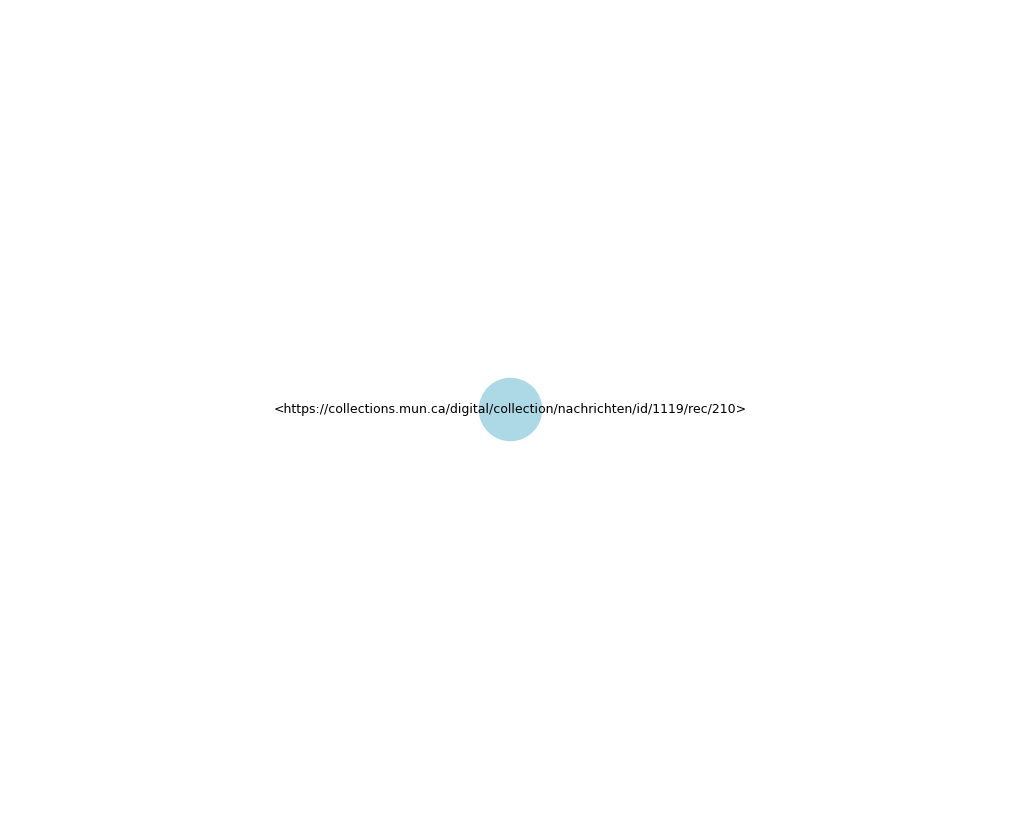

In [239]:
import rdflib
import networkx as nx
import matplotlib.pyplot as plt

# TTL-Datei laden
g = rdflib.Graph()
g.parse("data/5.6_Semantic_Web/Turtle-Herrnhut.ttl", format="turtle")

# Hilfsfunktion: URI kürzen (Namespace entfernen)
def shorten(node):
    if isinstance(node, rdflib.URIRef):
        return g.namespace_manager.normalizeUri(node)
    elif isinstance(node, rdflib.Literal):
        return str(node)
    elif isinstance(node, rdflib.BNode):
        return f"_:{node}"
    else:
        return str(node)

# In NetworkX umwandeln
G = nx.DiGraph()
for s, p, o in g:
    G.add_edge(s, o, predicate=shorten(p))

print(f"Knoten: {len(G.nodes())}, Kanten: {len(G.edges())}")

# ---- Nur einen kleinen Subgraph zeichnen ----
start_node = list(G.nodes())[50]
neighbors = list(G.neighbors(start_node))

sub_nodes = [start_node] + neighbors
H = G.subgraph(sub_nodes)

# Layout berechnen
pos = nx.spring_layout(H, seed=42)

# Labels für die Knoten vorbereiten
node_labels = {n: shorten(n) for n in H.nodes()}

# Zeichnen
plt.figure(figsize=(10, 8))
nx.draw(
    H, pos,
    labels=node_labels,
    with_labels=True,
    node_color="lightblue",
    node_size=2000,
    font_size=9
)

# Kantenlabels
edge_labels = nx.get_edge_attributes(H, 'predicate')
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=8)

plt.show()


                                           s  \
0  http://www.wikidata.org/entity/Q123456921   
1      naf13b18c89e2416c9f627e8c797bdb2eb193   
2      naf13b18c89e2416c9f627e8c797bdb2eb266   
3  http://www.wikidata.org/entity/Q123420358   
4      naf13b18c89e2416c9f627e8c797bdb2eb657   

                                              p  \
0      http://www.wikidata.org/prop/direct/P551   
1   http://www.wikidata.org/prop/statement/P551   
2   http://www.wikidata.org/prop/statement/P551   
3      http://www.wikidata.org/prop/direct/P551   
4  http://www.wikidata.org/prop/statement/P3342   

                                           o  
0     http://www.wikidata.org/entity/Q676689  
1     http://www.wikidata.org/entity/Q165140  
2     http://www.wikidata.org/entity/Q801238  
3    http://www.wikidata.org/entity/Q1501295  
4  http://www.wikidata.org/entity/Q123464538   (278, 3)
Knoten: 230, Kanten: 278


/var/folders/8w/sdx03mds5snd4v7gfh2rksz00000gn/T/ipykernel_97677/3959119236.py:66: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



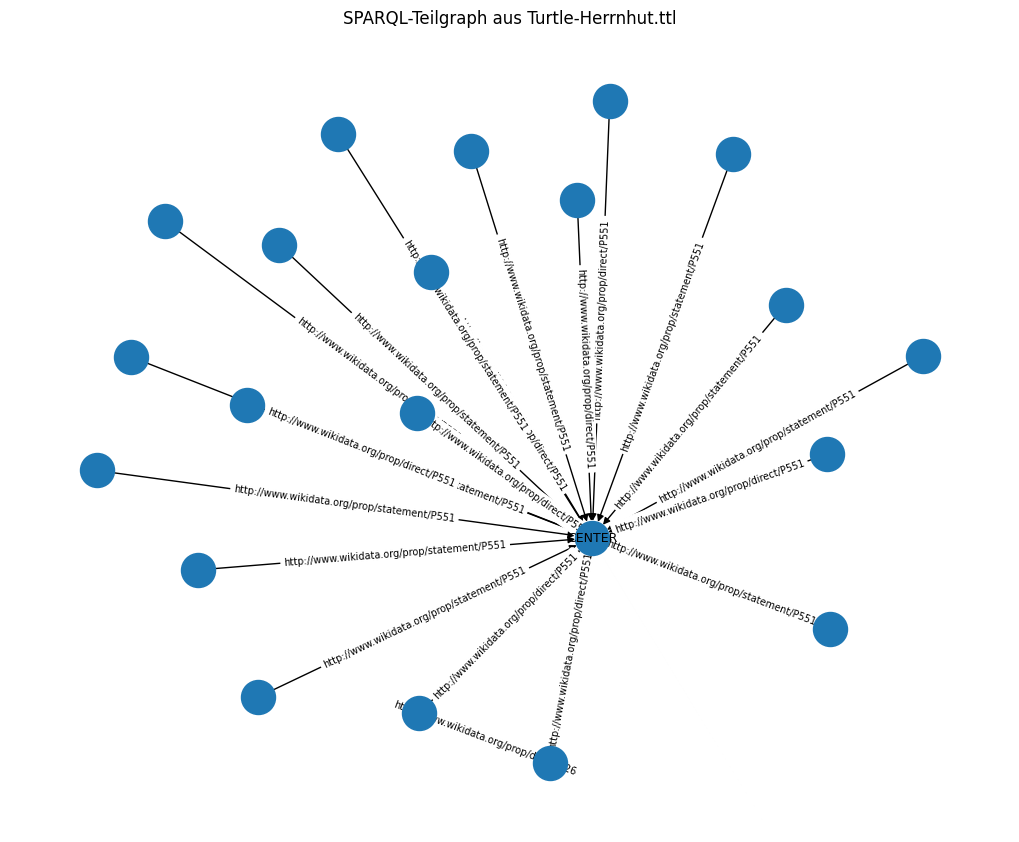

In [236]:
# pip install rdflib networkx pandas matplotlib

import rdflib
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# TTL laden
g = rdflib.Graph()
g.parse("data/5.6_Semantic_Web/Turtle-Herrnhut.ttl", format="turtle")

# Beispiel-SPARQL: wähle Tripel mit ausgewählten Prädikaten
# (Passe die P-Liste an deine Daten an; unten einige Wikidata-Property-IRIs als Beispiel.)
q = """
PREFIX wd:  <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX p:   <http://www.wikidata.org/prop/>
PREFIX ps:  <http://www.wikidata.org/prop/statement/>
PREFIX pq:  <http://www.wikidata.org/prop/qualifier/>

SELECT ?s ?p ?o
WHERE {
  ?s ?p ?o .
  # Beispiel: nur bestimmte Eigenschaften berücksichtigen (anpassen oder entfernen)
  FILTER(
    ?p IN (
      wdt:P26,                 # spouse
      wdt:P551,                # residence
      ps:P551,                 # residence (statement node)
      ps:P3342                 # significant person (nur Beispiel)
    )
  )
}
LIMIT 2000
"""

rows = []
for s, p, o in g.query(q):
    rows.append({"s": str(s), "p": str(p), "o": str(o)})

df = pd.DataFrame(rows)
print(df.head(), df.shape)

# In NetworkX überführen (gerichteter Graph)
G = nx.DiGraph()
for _, r in df.iterrows():
    G.add_edge(r["s"], r["o"], predicate=r["p"])

print(f"Knoten: {G.number_of_nodes()}, Kanten: {G.number_of_edges()}")

# Kleiner Subgraph zur Visualisierung (z. B. um einen „zentralen“ Knoten)
# -> wähle Knoten mit höchstem Grad
center = max(G.degree, key=lambda kv: kv[1])[0]
nbrs = list(G.successors(center)) + list(G.predecessors(center))
H = G.subgraph([center] + nbrs)

# Layout + Zeichnen
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(H, seed=7)
nx.draw(H, pos, with_labels=False, node_size=600)
# Labels sparsam: z. B. nur Knotenname des Zentrums + Kantenprädikate
nx.draw_networkx_labels(H, pos, labels={center: "CENTER"}, font_size=9)
edge_labels = nx.get_edge_attributes(H, "predicate")
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=7)
plt.title("SPARQL-Teilgraph aus Turtle-Herrnhut.ttl")
plt.tight_layout()
plt.show()


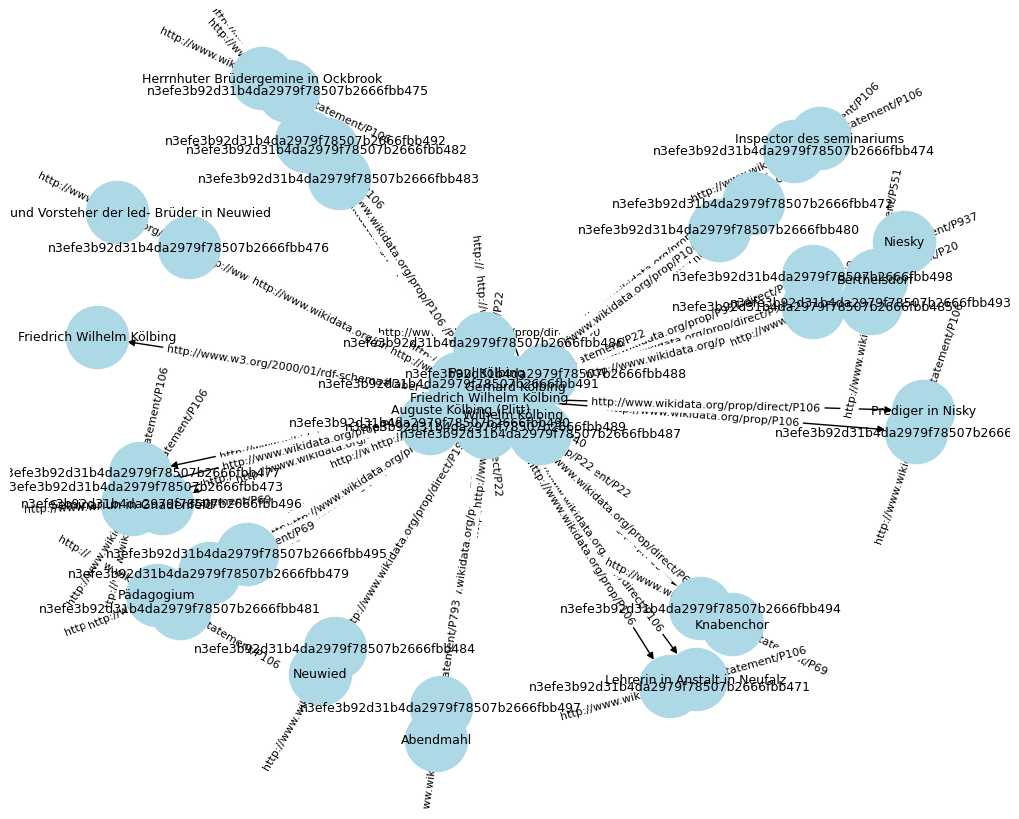

In [244]:
import rdflib
import networkx as nx
import matplotlib.pyplot as plt

# TTL-Datei laden
g = rdflib.Graph()
g.parse("data/5.6_Semantic_Web/Turtle-Herrnhut.ttl", format="turtle")

# Labels aus dem RDF holen (rdfs:label)
labels_dict = {}
for s, p, o in g.triples((None, rdflib.RDFS.label, None)):
    labels_dict[s] = str(o)  # Menschlich lesbarer Text

# In NetworkX umwandeln
G = nx.DiGraph()
for s, p, o in g:
    G.add_edge(s, o, predicate=str(p))

# ---- Subgraph erstellen ----
start_node = list(G.nodes())[0]
sub_nodes = nx.ego_graph(G, start_node, radius=1)  # nur 1-Hop Umgebung
H = G.subgraph(sub_nodes)

# Layout berechnen
pos = nx.spring_layout(H, seed=42)

# Labels für die Knoten: nur rdfs:label, fallback = URI/BlankNode
node_labels = {n: labels_dict.get(n, str(n).split("/")[-1]) for n in H.nodes()}

# Zeichnen
plt.figure(figsize=(10, 8))
nx.draw(
    H, pos,
    labels=node_labels,
    node_color="lightblue",
    node_size=2000,
    font_size=9
)

# Kantenlabels (optional, falls du Prädikate sehen willst)
edge_labels = nx.get_edge_attributes(H, 'predicate')
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=8)

plt.show()


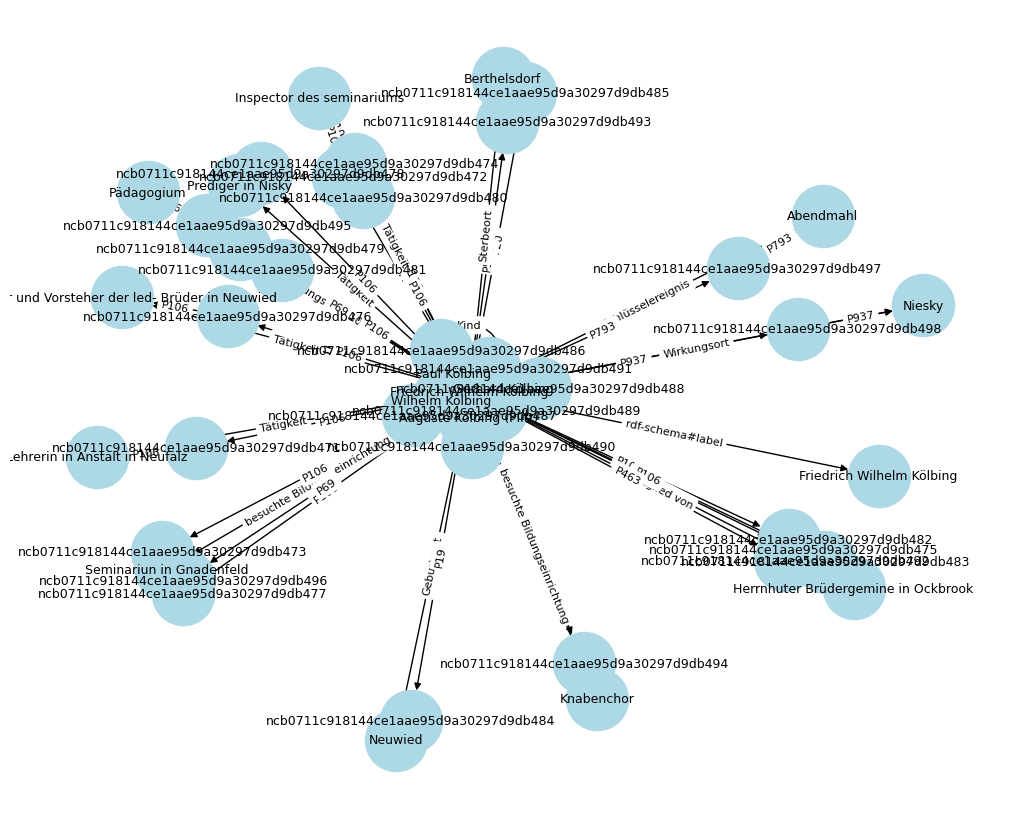

In [246]:
import rdflib
import networkx as nx
import matplotlib.pyplot as plt

# TTL-Datei laden
g = rdflib.Graph()
g.parse("data/5.6_Semantic_Web/Turtle-Herrnhut.ttl", format="turtle")

# Labels aus dem RDF holen (rdfs:label)
labels_dict = {}
for s, p, o in g.triples((None, rdflib.RDFS.label, None)):
    labels_dict[s] = str(o)  # Menschlich lesbarer Text

# In NetworkX umwandeln
G = nx.DiGraph()
for s, p, o in g:
    G.add_edge(s, o, predicate=p)  # speichere URIRef, nicht gleich str()

# ---- Subgraph erstellen ----
start_node = list(G.nodes())[0]
sub_nodes = nx.ego_graph(G, start_node, radius=1)  # nur 1-Hop Umgebung
H = G.subgraph(sub_nodes)

# Layout berechnen
pos = nx.spring_layout(H, seed=42)

# Labels für die Knoten: nur rdfs:label, fallback = URI/BlankNode
node_labels = {
    n: labels_dict.get(n, str(n).split("/")[-1]) for n in H.nodes()
}

# Labels für die Kanten: rdfs:label des Prädikats, fallback = QName/LocalName
edge_labels = {}
for u, v, data in H.edges(data=True):
    p = data["predicate"]
    label = labels_dict.get(p, str(p).split("/")[-1])
    edge_labels[(u, v)] = label

# Zeichnen
plt.figure(figsize=(10, 8))
nx.draw(
    H, pos,
    labels=node_labels,
    node_color="lightblue",
    node_size=2000,
    font_size=9
)
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=8)

plt.show()
